In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import numpy as np
# %matplotlib widget
from matplotlib import path
# import ipywidgets as widgets
from joblib import Parallel, delayed
from scipy import linalg
import multiprocessing
import matplotlib as mpl
# mpl.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
num_cores = multiprocessing.cpu_count() #import matplotlib.pyplot as plt
%config Completer.use_jedi = False
plt.rcParams.update({'font.size':16})
plt.rcParams['figure.figsize'] = [3,4]


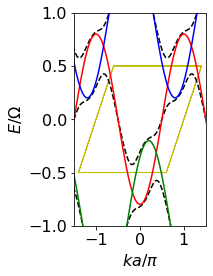

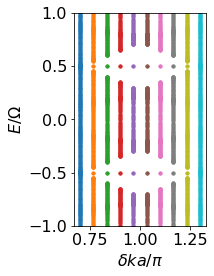

In [2]:
################################
# Global params
Nmax = 8
Nlist = np.arange(-Nmax+1,Nmax+1)
metric = np.diag([1.,-1.])
numFloquet = np.size(Nlist)

##############################
# params
# beta = (np.sqrt(5)-1)/2
beta = 0.4
w = 0.4
Delta = 0.3
a0 = np.array([2*np.pi,0])
a1 = np.array([2*np.pi*beta,1])
amat = np.array([a0,a1])
bmat = linalg.inv(amat.T)@metric*2*np.pi
b0 = bmat[0]
b1 = bmat[1]

klist = np.linspace(-2*np.pi,2*np.pi,100)
klist_pi = klist/np.pi

Nsites = 150
delta_k = 2*np.pi*beta

baseid = "w_" + str(w)+  "_Delta_" + str(Delta) +  "_beta_" + str(beta)


# Hamiltonian k space parameters
def h0_k(w,k):
    return -2*w*np.cos(k)
def h1_k(Delta,k):
    return Delta*np.cos(k+delta_k/2)


def hamiltonian(k,delta_k=delta_k,w=w,Delta=Delta):
    ham = np.diag(h1_k(Delta,k+Nlist[:-1]*delta_k),-1)
    ham = ham + ham.conj().T
    return ham + np.diag(-Nlist+h0_k(w,k+Nlist*delta_k))

def hamiltonian_realspace(w=w,Delta=Delta,Nsites=Nsites,delta_k=delta_k):
    ##############################
    # Hamiltonian real parameters
    tilde_h0_a = -w
    tilde_h0_ma = -w
    tilde_h1_a = Delta/2* np.exp(-1j*delta_k/2)
    tilde_h1_ma = Delta/2*np.exp(1j*delta_k/2)
    sitelist = np.arange(-int(Nsites/2),int(Nsites/2)+1)
    numsites = len(sitelist)
    h = np.diag(np.ones(numsites-1)*(-w),1) 
    h = h + h.conj().T
    V = tilde_h1_a*np.diag(np.ones(numsites-1),-1) + tilde_h1_ma*np.diag(np.ones(numsites-1),1)
    phaselist = np.exp(1j*delta_k*sitelist)
    V = V*phaselist[:,np.newaxis]
    ham = np.kron(np.diag(np.ones(numFloquet-1),-1),V)
    ham = -np.kron(np.diag(Nlist),np.eye(numsites)) + np.kron(np.eye(numFloquet),h) + ham + ham.conj().T 
    return ham,sitelist

def inner_product(a,b,metric=metric):
    return a@metric@(b.T)

def kebz(kmesh,Ek):
    kevec = np.array([kmesh,Ek]).T
    scoeff = inner_product(kevec,amat)/(2*np.pi)
    int_part,frac_part = np.divmod(scoeff+0.5,1)
    frac_part = frac_part - 0.5
    return int_part,frac_part

def plot_bz(ax,bmat,color='y'):
    bmat[:,1] = bmat[:,1]/np.pi
    origin_bz = -1/2*(bmat[0,:]+bmat[1,:])
    origin_bz1 = origin_bz + bmat[1,:]
    origin_bz0 = origin_bz + bmat[0,:]
    ax.arrow(origin_bz[1],origin_bz[0],bmat[1,1],bmat[1,0],color=color)
    ax.arrow(origin_bz[1],origin_bz[0],bmat[0,1],bmat[0,0],color=color)
    ax.arrow(origin_bz1[1],origin_bz1[0],bmat[0,1],bmat[0,0],color=color)
    ax.arrow(origin_bz0[1],origin_bz0[0],bmat[1,1],bmat[1,0],color=color)


def find_state_id(ee,numofid=2,target_energy=0.5):
    return np.argpartition(abs(ee-target_energy),numofid)[:numofid]

def plot_wf(ev,idx,sitelist,Nlist):
    fig,ax = plt.subplots()
    fig.tight_layout()
    plt.subplots_adjust(wspace =0, hspace =0)#调整子图间距
    numofsites = sitelist.shape[0]
    numofblocks = Nlist.shape[0]
    for jj in range(len(idx)):
        psisqr = np.abs(ev[:,idx[jj]])**2
        psisqr_sum = psisqr.reshape(numofblocks,numofsites).sum(axis=0)
        ax.plot(sitelist,psisqr_sum)

def convert_to_scoef(Ek,klist,amat=amat,bmat=bmat):
    Ekflat = Ek.flatten()
    klists = np.repeat(np.array([klist]).T,Ek.shape[1],axis=1).flatten()
    omega_k = np.array([Ekflat,klists]).T
    scoeff = inner_product(omega_k,amat)/(np.pi*2)
    return scoeff

    
#############################
# Solve in momentum-energy space
para_solve = lambda k : np.linalg.eigvalsh(hamiltonian(k))
# para_solve_2 = lambda k : np.linalg.eigvalsh(-hamiltonian(np.pi - k ))
results = Parallel(n_jobs=num_cores)(delayed(para_solve)(k) for k in klist)
# results_2 = Parallel(n_jobs=num_cores)(delayed(para_solve_2)(k) for k in klist)
Ek = np.array([results[jj] for jj in range(len(klist))])
# Ek_2 = np.array([results_2[jj] for jj in range(len(klist))])
fig,ax = plt.subplots()
fig.subplots_adjust(wspace=0.6, hspace=0.6, left=0.35, bottom=0.22, right=0.96, top=0.96)
ax.plot(klist_pi,Ek,'k--')
ax.plot(klist_pi,h0_k(w,klist),'r-')
ax.plot(klist_pi,h0_k(w,klist+delta_k)-1,'g-')
ax.plot(klist_pi,h0_k(w,klist-delta_k)+1,'b-')
plot_bz(ax,bmat)
ax.set_ylim([-1,1])
ax.set_xlim([-1.5,1.5])
ax.set_xlabel(r'$ka/\pi$')
ax.set_ylabel(r'$E/\Omega$')
fig.savefig('bands' + baseid + '.png',dpi=300)

#############################
# # # solve in real space
philist = np.linspace(0,2*np.pi,3)
fig,ax = plt.subplots()
plt.subplots_adjust(wspace=0.6, hspace=0.6, left=0.35, bottom=0.22, right=0.96, top=0.96)
# for phi in philist:
deltaklist = np.linspace(0.5-0.15,0.5+0.15,10)*2*np.pi
for delta_k in deltaklist:
    ham_real,sitelist = hamiltonian_realspace(w=w,Delta=Delta,delta_k=delta_k)
    ee,ev = np.linalg.eigh(ham_real)
    ax.plot(np.ones(len(ee))*delta_k/np.pi,ee,'.')
ax.set_ylim([-1,1])
ax.set_ylabel(r'$E/\Omega$')
ax.set_xlabel(r'$\delta k a/\pi$')
fig.subplots_adjust(wspace=0.6, hspace=0.6, left=0.35, bottom=0.22, right=0.96, top=0.96)
fig.savefig('OBC_' + baseid + '.png',dpi=300)



In [3]:
fig.savefig('OBC_' + baseid + '.png',dpi=300)